# __This notebook will be used to investigate and implement different classification models using the iris data set__

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math



### __Loading data set__

In [ ]:
IRIS_DATASET = pd.read_csv("iris data set\iris.csv")
iris_df = pd.DataFrame(IRIS_DATASET)
print(iris_df.head(5))

   Id  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm      Species
0   1            5.1           3.5            1.4           0.2  Iris-setosa
1   2            4.9           3.0            1.4           0.2  Iris-setosa
2   3            4.7           3.2            1.3           0.2  Iris-setosa
3   4            4.6           3.1            1.5           0.2  Iris-setosa
4   5            5.0           3.6            1.4           0.2  Iris-setosa


### __Visualizing data__

Unique species:  ['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']


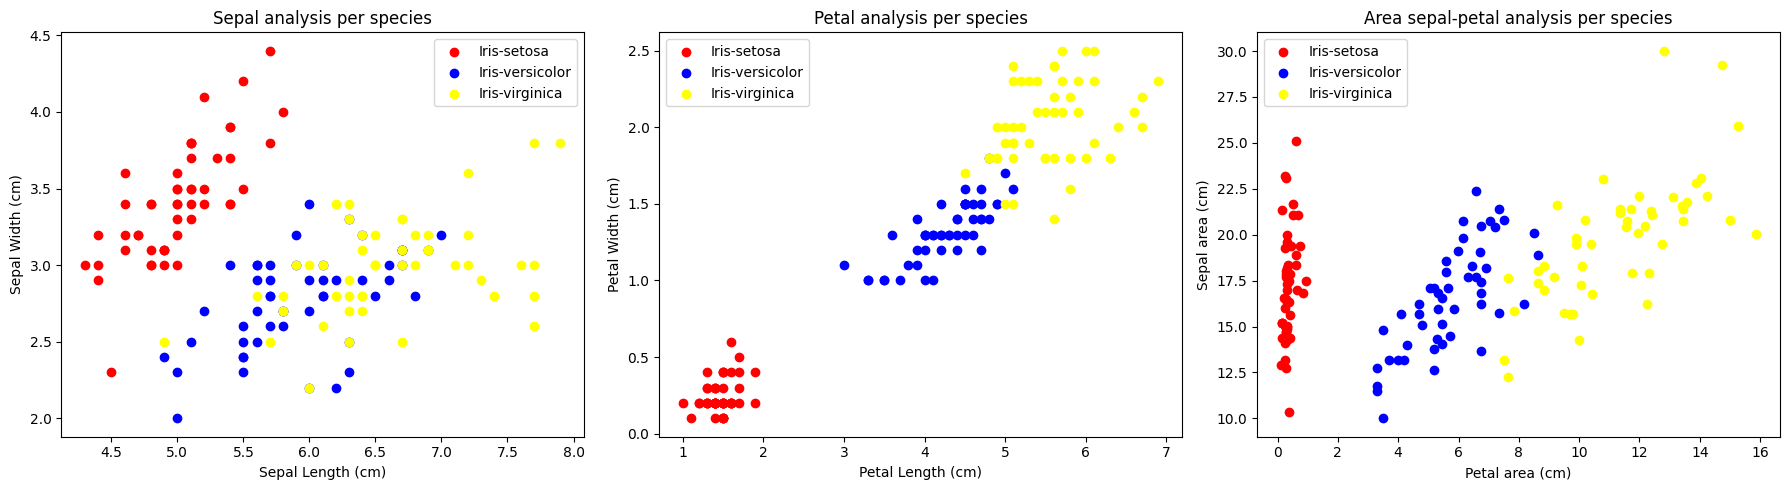

In [ ]:

species = iris_df["Species"].unique()
print("Unique species: ", species)

colors = {
    "Iris-setosa": "red",
    "Iris-versicolor": "blue",
    "Iris-virginica":"yellow"
}

# Create a figure with 3 side-by-side axes
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1 row, 3 columns

# species data frame
setosa_df = iris_df[iris_df["Species"] == "Iris-setosa"]
virginica_df = iris_df[iris_df["Species"] == "Iris-virginica"]
versicolor_df = iris_df[iris_df["Species"] == "Iris-versicolor"]

# print(f"\n setosa \n {setosa_df.head()}")
# print(f"\n virginica \n {virginica_df.head()}" )
# print(f"\n versicolor \n {versicolor_df.head()}")

# sepal area between species 
for sp in species:
    subset = iris_df[iris_df["Species"] == sp]
    # compiles till we plot
    axes[0].scatter(
        subset["SepalLengthCm"], 
        subset["SepalWidthCm"], 
        color=colors[sp], 
        label=sp
    )

axes[0].set_xlabel("Sepal Length (cm)")
axes[0].set_ylabel("Sepal Width (cm)")
axes[0].set_title("Sepal analysis per species")
axes[0].legend()


# petal area between species 
for sp in species:
    subset = iris_df[iris_df["Species"] == sp]
    # compiles till we plot
    axes[1].scatter(
        subset["PetalLengthCm"], 
        subset["PetalWidthCm"], 
        color=colors[sp], 
        label=sp
    )

axes[1].set_xlabel("Petal Length (cm)")
axes[1].set_ylabel("Petal Width (cm)")
axes[1].set_title("Petal analysis per species")
axes[1].legend()

# area petal-sepal analysis
for sp in species:
    subset = iris_df[iris_df["Species"] == sp]
    # compiles till we plot
    axes[2].scatter(
        subset["PetalLengthCm"] * subset["PetalWidthCm"], 
        subset["SepalLengthCm"] * subset["SepalWidthCm"],
        color=colors[sp], 
        label=sp
    )

axes[2].set_xlabel("Petal area (cm)")
axes[2].set_ylabel("Sepal area (cm)")
axes[2].set_title("Area sepal-petal analysis per species")
axes[2].legend()

plt.tight_layout()
plt.show()

### **Baseline & Simple Models**
1. Logistic regression
    - Vanilla python

In [ ]:
def softmax(logits):
    """
    logits: shape (N, K)
    returns: probabilities, shape (N, K)
    What to do:
    - Apply the softmax equation to each row
    - Use max subtraction for numerical stability
    """
    # case 1: 1 sample -> for prediction 
    if logits.ndim == 1:
        logits = logits - np.max(logits)
        exp_logits = np.exp(logits)
        return exp_logits / np.sum(exp_logits)
    # case 2: batch (n,k) 
    else:
        logits = logits - np.max(logits, axis=1, keepdims=True)
        exp_logits = np.exp(logits)
        return exp_logits / np.sum(exp_logits, axis=1, keepdims=True)


def cross_entropy_loss(probs, y_true):
    """
    probs: predicted probabilities (N, K)
    y_true: correct labels (N,) — each is class index 0..K-1
    returns: scalar loss
    What to do:
    - Pick the predicted prob for the correct class for each sample
    - Take the negative log
    - Average over N
    """
    N = len(probs)

    # one hot code y_true
    correct_prob = probs[np.arange(N), y_true]

    # calculate the log loss of each probability 
    negative_logs = -np.log(correct_prob)

    # calculate the batch loss
    average_loss = np.mean(negative_logs)

    return average_loss

    


def forward(X, W, b):
    """
    X: input data (N, D)
    W: weights (D, K)
    b: biases (K,)
    returns: logits (N, K)
    What to do:
    - Compute XW + b
    """
    return X @ W + b  


def backward(X, probs, y_true, lr, W, b):
    """
    X: (N, D)
    probs: (N, K)
    y_true: (N,)
    returns: gradients dW, db
    What to do:
    - Convert y_true into one-hot
    - Compute derivative of loss w.r.t. logits
    - Get dW and db
    """
    N = len(X)

    dJ_dW = (1/N) * np.matmul(np.transpose(X), probs - encoded_y_true )
    dL_db = (1/N) * np.sum(probs - encoded_y_true, axis=0)

    return  dJ_dW, dL_db



def train(X, Y, lr=0.1, epochs=1, train_batch=True):
    """
    Train loop:
    - Initialize W, b
    - For each epoch:
        - Forward pass → logits → softmax
        - Compute loss
        - Backward pass → gradients
        - Update W, b with gradient descent
    - Return trained W, b
    """
    # seperate testing and training data 
    N = len(iris_df)
    indices = np.arange(N)
    np.random.shuffle(indices)
    
    split = int(N * .8)
    
    train_idx = indices[:split]
    test_idx = indices[split:]

    
    Xtrain = X[train_idx]
    Xtest = X[test_idx]
    Ytrain = Y[train_idx]
    Ytest = Y[train_idx]

    # initialize weight and biases
    w = np.zeros((np.shape(Xtrain)[1], 3)) # 1x4 feature * 4 (len of x) x 3 (output)
    b = np.zeros(3,) 

    for epoch in range(epochs): 

        logits =  forward(Xtrain, w, b)      # returns z
        probability = softmax(logits)   # computes the probability 

        loss = cross_entropy_loss(probability, Ytrain)

    return w, b 

# extracting paramters 
# Drop the label column (Species)
X = iris_df.drop(columns=["Species", "Id"]).values

# Grab the label column separately
y = iris_df["Species"].values

# Process category in numerical format (easy way -> y = iris_df["Species"].astype('category').cat.codes.values)
true_y = []
label = {
    "Iris-setosa": 0,
    "Iris-versicolor": 1,
    "Iris-virginica":2
}
for specie in y:
    true_y.append(label[specie])

# get weight and bias for prediction 
print("hello??")
w, b = train(X, np.array(true_y))

[[0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33

### __KNN prediction__
#### Vanilla python 